## JSON 소켓 통신 with Android

소켓통신을 해보았고 다음과 같은 이슈가 있었습니다.

### Reading Messages

JSON bytes stream을 받을 때, 실시간으로 고용량을 보내기 때문에 들어오는 크기가 제각각 이였습니다.  

따라서 JSON 마지막 구분자 `}`가 들어올 때 까지 무작정 받기로 했습니다.

(대신 string concat 메모리 비효율 문제가 있음)

###  Message re-encoding issue

메세지를 다시 base64로 인코딩을 할때, numpy array에서 base64모듈을 사용해 인코딩을 하는데  

크기가 5배 가까이 증가하는 현상을 보임, 이후 해결해야할 과제로 보이나,

일단 안드로이드가 받은 메세지를 이미지로 번역하는 과정을 기다려야함.

## 서버열고 안드로이드에서 받음

In [ ]:
import json
import socket
import base64
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import PIL

In [21]:
PORT = 12321
HOST = '192.168.0.2'
BACKLOG = 10

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((HOST, PORT))
s.listen(BACKLOG)
conn, addr = s.accept()
conn, addr

(<socket.socket fd=2000, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.2', 12321), raddr=('175.223.26.55', 57813)>,
 ('175.223.26.55', 57813))

In [22]:
all_msg = ""
PACKET_LEN = 1024 ** 2

In [23]:
while all_msg[-1:] != "}":
    while True:
        temp = conn.recv(PACKET_LEN)
        print(len(temp))
        all_msg += temp.decode('utf-8')
        if len(temp) < PACKET_LEN:
            break
        
len(all_msg), type(all_msg), all_msg

11280
991081


(1002361,
 str,
 '{"msgId":"1","encodedType":"base64","image":"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEB\nAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEB\nAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAL0A/ADASIA\nAhEBAxEB/8QAHwAAAgIDAAMBAQAAAAAAAAAABwgGCQQFCgACAwEL/8QAQxAAAgMBAAIBAwQCAQMD\nAAAXAwQBAgUGBxESCBMUABUhIgkxIxYyQRckUTNCYQolcRhSGTRDgZEmJzUaYnKhscHw/8QAHQEA\nAgMBAQEBAQAAAAAAAAAABQYDBAcCCAEACf/EAEgRAAICAQMCBQIEBAQFAwIBDQECAxEEBRIhADEG\nEyJBURRhBzJxgRUjQpFSobHBFiQz0fBi4fEIQ3IXJbI0NVNjgpKiGERF/9oADAMBAAIRAxEAPwDj\np8n+Aex8a3v0mYCeg4urMTdnKrdpzBtPyvUegGn272TmYgSj3q0zM2BFanm1z7vgPKqpcrD5DrZJ\nGZlaLexgdjzwhrdRlOznhBk/k6JjW9ZWYyqNga32lbxNiUCwAcDpV6SmAutFf/fs3rNK/bvNS0ve\nRx/xloW1aWGUERQ1b2qG0EtJPcXvF1Q8qeDkmBX3vH6wMzU+f3WuYPK6qehFq1uS2TWPayxy+rEo\nM01oS5SVqdcZKLfpF8MePCZoYs8JHMsiLHkBahm7LtmUEiMk8h1pfslWXPxF4MMUM0uCTLB5ZLwM\nbljBpi0R43qK5BO/v+awOmo57zrndJha+F5QYSL09ue2c3B8iWx39Bfrwm2MLYzEeqRW0RjukNrH\nW

In [24]:
conn.close()
s.close()

In [25]:
len(all_msg)

1002361

In [26]:
split_msg = all_msg.split('"')

for i, msg in enumerate(split_msg):
    print(i, len(msg))

0 1
1 5
2 1
3 1
4 1
5 11
6 1
7 6
8 1
9 5
10 1
11 1002314
12 1


In [27]:
base_code = "".join(split_msg[11:-1])
len(base_code)

1002314

In [28]:
base64_decode = base64.b64decode(base_code)
len(base64_decode)

741970

In [29]:
type(base64_decode)

bytes

In [30]:
base64_decode[:10]

b'\xff\xd8\xff\xe0\x00\x10JFIF'

In [31]:
bytes_image = io.BytesIO(base64_decode)
img = mpimg.imread(bytes_image, format="JPG")

In [32]:
type(img)

numpy.ndarray

In [33]:
img.shape

(756, 1008, 3)

In [34]:
len(img.base)

2286144

In [35]:
img.base[:1000]

b'\t\t\x07\x0c\x0c\n\x0c\x0e\r\x0b\r\x0c\x12\x10\x11\x0e\x0c\r\x10\x10\x12\x17\x18\x1a\x15\x16\x1a04703:7<B\'.8\x13\x1d\'\x16"0DQbds\x88Wg~IYs+<V 2Jo\x7f\x96\x19(=$3F/AUo\x81\x95\x94\xa5\xb7IVg\x02\n\x17\x18\x1b"&%!+\'\x1e)"\x18\x0f\x0b\x02\x07\x06\x04\x06\x08\x07\x04\x08\t\x01\x07\x07\x04\x08\t\x03\x07\x08\x01\x06\t\x06\x0b\x0e\x08\r\x13\x0b\x12\x18\x11\x18 .9?U_i>KT\x06\x0e\x19\x00\x05\x0e\x04\x08\x13\r\x14\x1e2?Hl}\x87\x9a\xaa\xb79IV\x0f\x1c,\x10\x1c*\x1d&51=IFVeew\x85_o|$2=OV`!"\'/%$5&!=+!?+ ?)\x1c@*\x1d;(\x1a>+\x1dD.!C-\x1fD-\x1bF0\x1bA,\x1bA,\x1bF1 D/\x1cF1\x1eF1\x1cI5\x1dH4\x1cJ5 H4\x1cT@(fR9\x80nX\x9a\x89u\xab\x9b\x8b\xb7\xab\x9d\xb4\xaa\xa1\xb7\xb0\xa8\xb2\xaa\xa7\xb3\xae\xaa\xb3\xad\xad\xb4\xae\xae\xb3\xaf\xb0\xb5\xb1\xb2\xb5\xb1\xb0\xb3\xaf\xae\xb3\xb1\xb2\xb4\xb2\xb3\xb5\xb3\xb6\xb5\xb3\xb6\xb3\xb2\xb7\xb5\xb4\xb9\xb5\xb4\xb9\xb4\xb3\xb8\xb4\xb3\xb8\xb4\xb3\xb8\xb7\xb5\xba\xb8\xb6\xbb\xba\xb9\xbf\xba\xb9\xbf\xb8\xb7\xbd\xbc\xbb\xc1\xb9\xb8\xbe\xbc\xbb\xc1\xbb\xba\xc2\xbb\xb

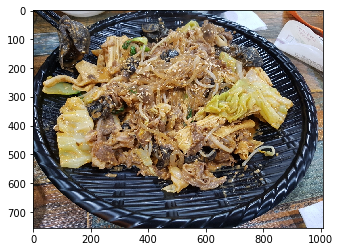

In [36]:
plt.imshow(img)
plt.show()

In [37]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("./test_file.jpg", img)

True

## 서버 열고 안드로이드로 전송

In [38]:
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((HOST, PORT))
s.listen(BACKLOG)
conn, addr = s.accept()
conn, addr

(<socket.socket fd=776, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.2', 12321), raddr=('175.223.26.55', 54876)>,
 ('175.223.26.55', 54876))

In [20]:
encoded_string = None
with open("./test_file.jpg", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())

In [21]:
len(encoded_string)

78556

In [22]:
type(encoded_string)

bytes

In [23]:
send_msg_dict = {
    "TiredScore": 0.98,
    "image": str(encoded_string)
}

In [24]:
json_msg = json.dumps(send_msg_dict)
type(json_msg), len(json_msg)

(str, 78592)

In [25]:
conn.sendall(json_msg.encode('utf-8'))

In [56]:
conn.close()
s.close()

## Encoded image test

In [27]:
with open("encoded_text.txt", "w") as f:
    f.write(str(encoded_string))

In [28]:
str_encoded = str(encoded_string)

In [29]:
type(encoded_string), type(str_encoded)

(bytes, str)

In [30]:
str_encoded[:100]

"b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQ"

In [31]:
for i, d in enumerate(str_encoded.split("'")):
    print(i, len(d))

0 1
1 78556
2 0


In [32]:
str_encoded.split("'")[1][:10], str_encoded.split("'")[1][-10:]

('/9j/4AAQSk', 'tobAf/2Q==')

In [33]:
test_base = base64.b64decode(str_encoded.split("'")[1])

In [34]:
type(test_base)

bytes

In [35]:
bytes_image = io.BytesIO(test_base)
img = mpimg.imread(bytes_image, format="JPG")
img.shape

(486, 648, 3)

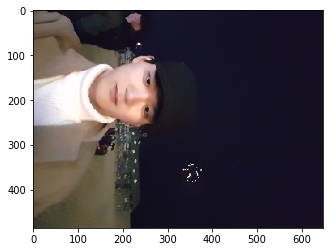

In [36]:
plt.imshow(img)
plt.show()